In [158]:
import pandas as pd
import seaborn as sns
%pylab inline
pd.options.display.max_seq_items = 2000
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import requests, re
import pandas as pd
import seaborn as sns
import nltk
import string, itertools
import csv
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import folium

plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


### Clean yelp_business dataset

In [4]:
business_json_path = '../yelp_dataset/yelp_academic_dataset_business.json'
business = pd.read_json(business_json_path, lines=True)
print(business.shape)
business.head()

(150346, 14)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [6]:
## filter restaurants of US
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
usa=business.loc[business['state'].isin(states)]
print(usa.shape)
usa.head()

(144771, 14)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [22]:
## select all restaurants in USA
us_restaurants=usa[usa['categories'].str.contains('Restaurants', na = False)]

## select out 16 cuisine types of restaurants and rename the category
def categorize(row):
    categories_to_check = ['Chinese', 'American', 'French', 'Japanese','Mexican','Thai','Mediterranean','Vietnamese','Korean','Italian','Greek','Indian','Hawaiian']
    
    for category in categories_to_check:
        if category in row['categories']:
            return category
    
    return None

us_restaurants['category'] = us_restaurants.apply(categorize, axis=1)

## drop null values in category, delete original column categories and reset the index
us_restaurants=us_restaurants.dropna(axis=0, subset=['category'])
us_restaurants = us_restaurants.drop(['categories', 'attributes','hours'], axis=1)
us_restaurants=us_restaurants.reset_index(drop=True)
us_restaurants = us_restaurants.rename(columns={'stars': 'avg_star'})
print(us_restaurants.shape)
us_restaurants.head(10)


(28262, 12)


/var/folders/8f/c3wp81s97mx_4cyjt0ks4rc80000gn/T/ipykernel_92669/246534236.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_restaurants['category'] = us_restaurants.apply(categorize, axis=1)


,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,is_open,category
0,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,American
1,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,Vietnamese
2,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,American
3,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,Italian
4,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,Japanese
5,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,Korean
6,9OG5YkX1g2GReZM0AskizA,Romano's Macaroni Grill,5505 S Virginia St,Reno,NV,89502,39.476117,-119.789339,2.5,339,1,Italian
7,tMkwHmWFUEXrC9ZduonpTg,The Green Pheasant,215 1st Ave S,Nashville,TN,37201,36.159886,-86.773197,4.0,161,0,Japanese
8,QdN72BWoyFypdGJhhI5r7g,Bar One,767 S 9th St,Philadelphia,PA,19147,39.939825,-75.157447,4.0,65,0,Italian
9,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,Philadelphia,PA,19123,39.962582,-75.135657,3.5,65,1,American


In [23]:
## check whether has duplicated business id
us_restaurants.business_id.duplicated().sum()

0

In [24]:
## check missing values
us_restaurants.isnull().sum()

business_id     0
name            0
address         0
city            0
state           0
postal_code     0
latitude        0
longitude       0
avg_star        0
review_count    0
is_open         0
category        0
dtype: int64

In [25]:
## check the datatype
us_restaurants.dtypes

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
avg_star        float64
review_count      int64
is_open           int64
category         object
dtype: object

### Merge two datasets and get new df restaurants_reviews

In [28]:
# Set up your local path
review_json_path = '../yelp_dataset/yelp_academic_dataset_review.json'
size = 1000000
review = pd.read_json(review_json_path, lines=True,
                      # identifying the data type of each column can reduce memory usage
                      dtype={'review_id':str,'user_id':str,'business_id':str,'stars':int,
                             'date':str,'text':str,'useful':int,'funny':int,'cool':int},
                      chunksize=size)

In [30]:
# There are multiple chunks to be read
chunk_list = []
for chunk in review:
    # Drop columns that aren't needed
    chunk = chunk.drop(['review_id','useful','funny','cool'], axis=1)
    # Renaming column name to avoid conflict with business overall star rating
    chunk = chunk.rename(columns={'stars': 'review_star'})
    # Inner merge with edited business file so only reviews related to the business remain
    chunk_merged = pd.merge(us_restaurants, chunk, on='business_id', how='inner')
    chunk_list.append(chunk_merged)
    
# After trimming down the review file, concatenate all relevant data back to one dataframe
restaurants_reviews = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

In [34]:
print(restaurants_reviews.shape)
restaurants_reviews.head()

(3172420, 16)


,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,is_open,category,user_id,review_star,text,date
0,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,American,LNprC9Mi8Xqtgk1KCFlKAg,4,"I like Tsevis because they have good gyros, wh...",2014-02-25 22:34:59
1,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,American,z-i_Qv-E3qeHfdPZddpwYQ,4,Good Greek American food. I highly recomend th...,2013-01-29 04:27:04
2,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,American,m6YhwUNoehMm6s52w9A4eA,2,Wife and I have eaten lunch here a few times o...,2013-10-25 15:39:01
3,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,American,-YAnRx8VSDkASxlylv3dyg,1,After about 7 minutes of waiting patiently for...,2014-07-16 19:17:34
4,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,American,WJ-veSDe63t0HnCu2E1NSA,1,Three of us decided to try this place out last...,2012-12-17 18:37:23


In [35]:
## add column of number of words in review 
restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','').map(lambda x: len(x.split()))
# label of negative and postive reviews
restaurants_reviews['labels'] = ''
restaurants_reviews.loc[restaurants_reviews.review_star >=4, 'labels'] = 'positive'
restaurants_reviews.loc[restaurants_reviews.review_star ==3, 'labels'] = 'neural'
restaurants_reviews.loc[restaurants_reviews.review_star <3, 'labels'] = 'negative'
# drop neutral reviews for easy analysis
restaurants_reviews.drop(restaurants_reviews[restaurants_reviews['labels'] =='neural'].index, axis=0, inplace=True)
restaurants_reviews.reset_index(drop=True, inplace=True)

restaurants_reviews.head()

/var/folders/8f/c3wp81s97mx_4cyjt0ks4rc80000gn/T/ipykernel_92669/3808488812.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n',''). \


,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,is_open,category,user_id,review_star,text,date,num_words_review,labels
0,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,American,LNprC9Mi8Xqtgk1KCFlKAg,4,"I like Tsevis because they have good gyros, wh...",2014-02-25 22:34:59,53,positive
1,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,American,z-i_Qv-E3qeHfdPZddpwYQ,4,Good Greek American food. I highly recomend th...,2013-01-29 04:27:04,26,positive
2,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,American,m6YhwUNoehMm6s52w9A4eA,2,Wife and I have eaten lunch here a few times o...,2013-10-25 15:39:01,184,negative
3,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,American,-YAnRx8VSDkASxlylv3dyg,1,After about 7 minutes of waiting patiently for...,2014-07-16 19:17:34,186,negative
4,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,American,WJ-veSDe63t0HnCu2E1NSA,1,Three of us decided to try this place out last...,2012-12-17 18:37:23,224,negative


### EDA

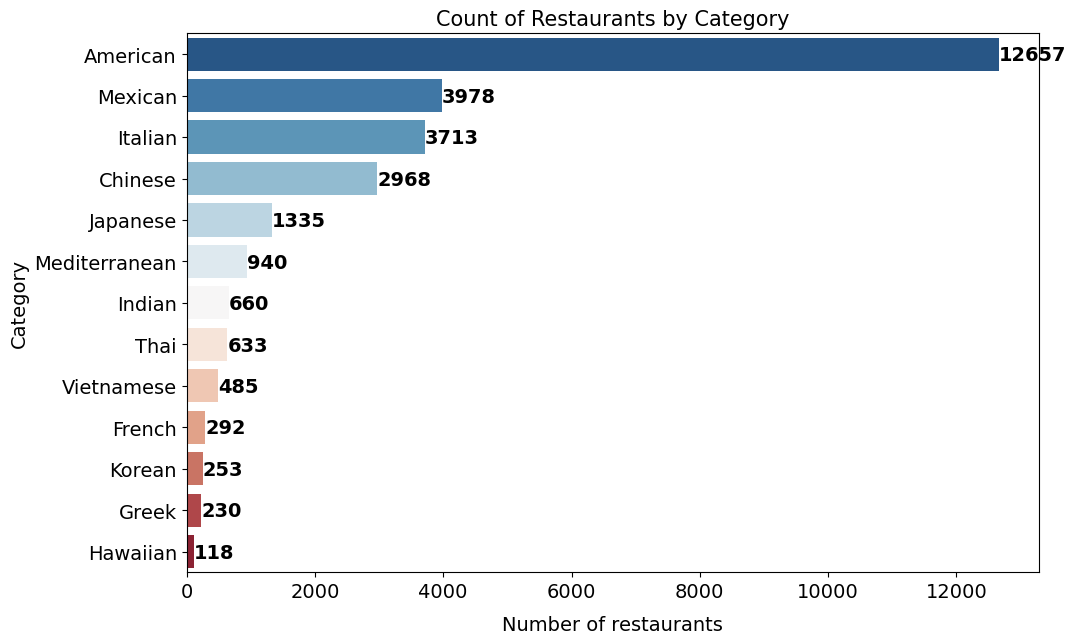

In [41]:
# Distribution of restaurants in each category
plt.figure(figsize=(11,7))
grouped = us_restaurants.category.value_counts()
sns.countplot(y='category',data=us_restaurants, 
              order = grouped.index, palette= sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Number of restaurants', fontsize=14, labelpad=10)
plt.ylabel('Category', fontsize=14)
plt.title('Count of Restaurants by Category', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(us_restaurants.category.value_counts()):
    plt.text(v, i+0.15, str(v), fontweight='bold', fontsize=14)

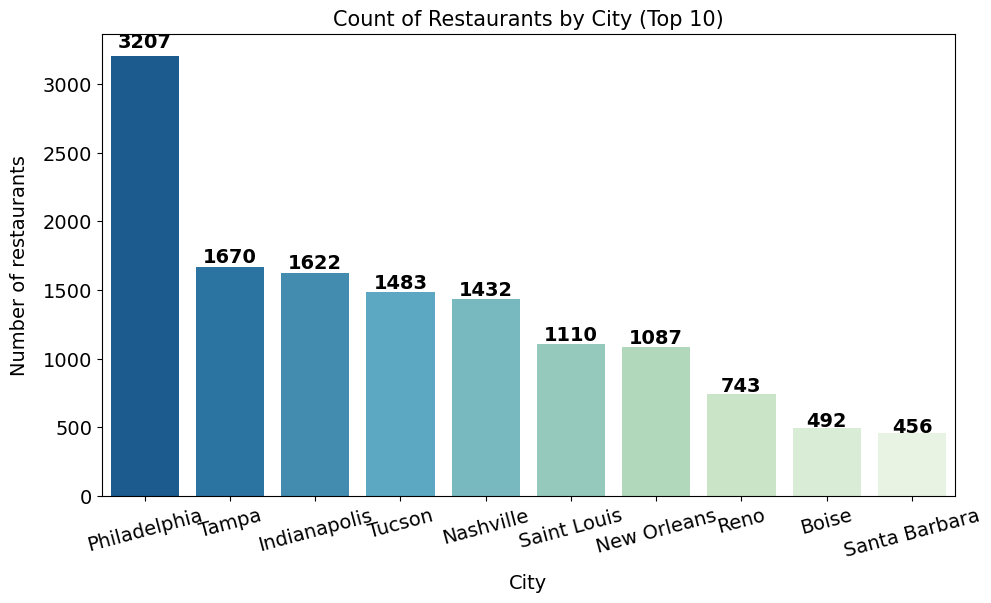

In [43]:
# Top 10 cities with most restaurants
plt.figure(figsize=(11,6))
grouped = us_restaurants.city.value_counts()[:10]
sns.barplot(x = grouped.index, y= grouped.values, palette=sns.color_palette("GnBu_r", len(grouped)))
plt.ylabel('Number of restaurants', fontsize=14, labelpad=10)
plt.xlabel('City', fontsize=14, labelpad=10)
plt.title('Count of Restaurants by City (Top 10)', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

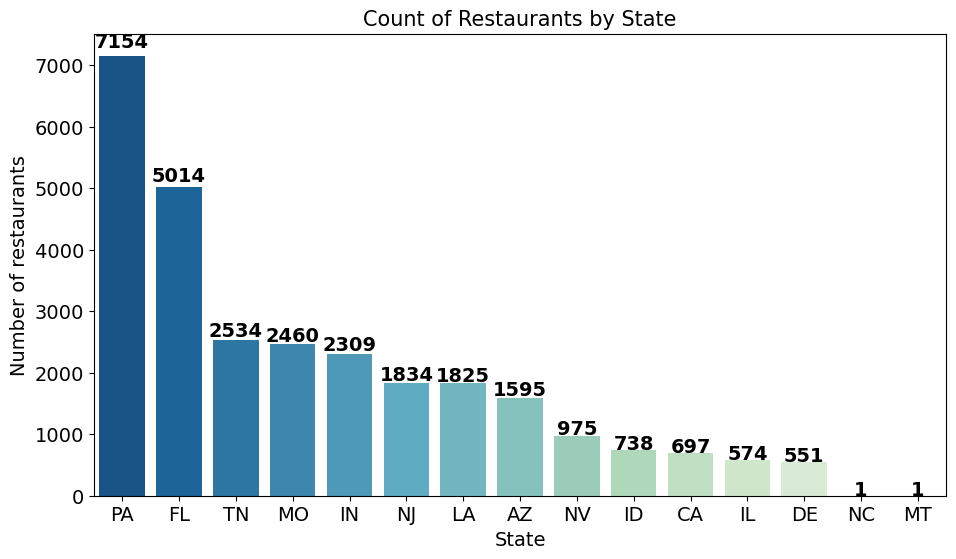

In [44]:
# Distribution of restaurants in each state
plt.figure(figsize=(11,6))
grouped = us_restaurants.state.value_counts()
sns.barplot(x = grouped.index, y =grouped.values,palette=sns.color_palette("GnBu_r", len(grouped)) )
plt.ylabel('Number of restaurants', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.title('Count of Restaurants by State', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center', fontweight='bold', fontsize=14)

In [ ]:
res_locations = us_restaurants[["latitude", "longitude", "business_id"]]
map = folium.Map(location=[res_locations.latitude.mean(), res_locations.longitude.mean()], zoom_start=14, control_scale=True)
for index, location_info in res_locations.iterrows():
    folium.Marker([location_info["latitude"], location_info["longitude"]], popup=location_info["business_id"]).add_to(map)
map

In [163]:
us_restaurants.groupby('category')['business_id'].count().reset_index()

,category,business_id
0,American,12657
1,Chinese,2968
2,French,292
3,Greek,230
4,Hawaiian,118
5,Indian,660
6,Italian,3713
7,Japanese,1335
8,Korean,253
9,Mediterranean,940


In [182]:

state_geo = 'https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json'

#French_res = us_restaurants[us_restaurants['category'] == 'Korean'].groupby('state')['business_id'].count().reset_index()
#French_res.columns = ['State', 'count']

res = us_restaurants.groupby('state')['business_id'].count().reset_index()
res.columns = ['State', 'count']
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=res,
    columns=["State", "count"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Count of Resteruant",
).add_to(m)

folium.LayerControl().add_to(m)

m
m.save("resteruant_map.html")

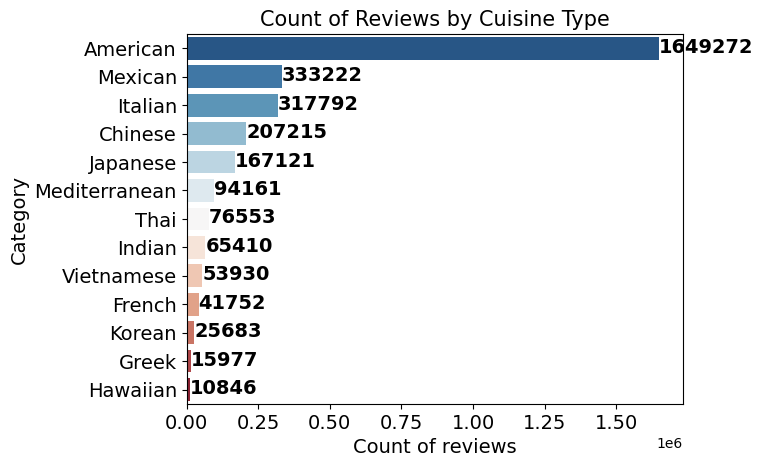

In [45]:
#Distribution of reviews by cuisine typeplt.figure(figsize=(11,7))
grouped = us_restaurants.groupby('category')['review_count'].sum().sort_values(ascending = False)
sns.barplot(y=grouped.index, x= grouped.values, palette= sns.color_palette("RdBu_r", len(grouped)) )
plt.ylabel('Category', fontsize=14)
plt.xlabel('Count of reviews', fontsize=14)
plt.title('Count of Reviews by Cuisine Type', fontsize=15)
for i,v in enumerate(grouped):
    plt.text(v, i+0.15, str(v),fontweight='bold', fontsize=14)
plt.tick_params(labelsize=14)

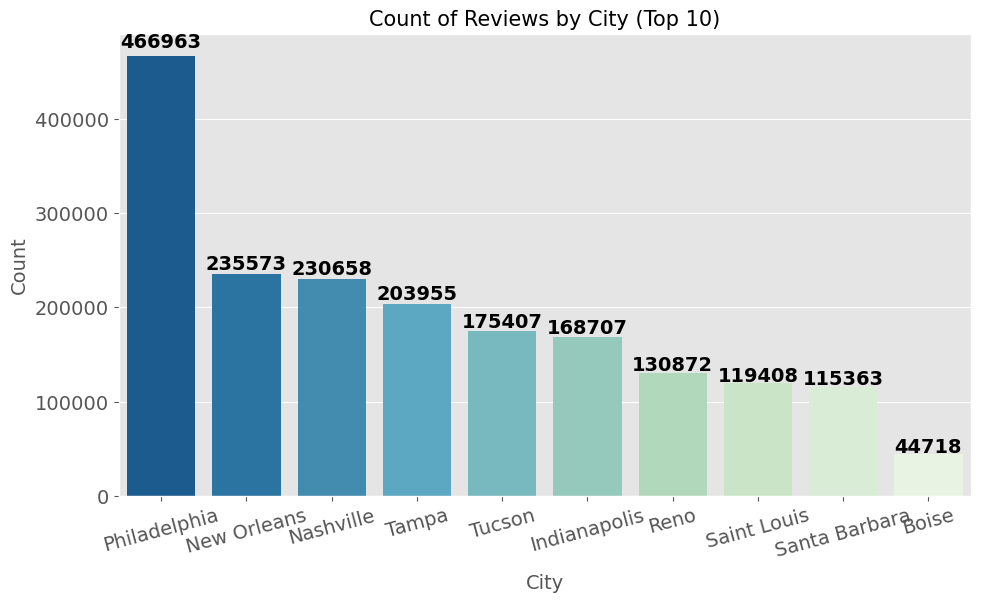

In [61]:
#Top 10 cities with most reviews
plt.figure(figsize=(11,6))
grouped = us_restaurants.groupby('city')['review_count'].sum().sort_values(ascending=False)[:10]
sns.barplot(x = grouped.index, y = grouped.values, palette=sns.color_palette("GnBu_r", len(grouped)) )
plt.xlabel('City', labelpad=10, fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Reviews by City (Top 10)', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

/var/folders/8f/c3wp81s97mx_4cyjt0ks4rc80000gn/T/ipykernel_92669/904672086.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=grouped.review_count, y = grouped.name, palette=sns.color_palette("GnBu_r", len(grouped)), ci=None)


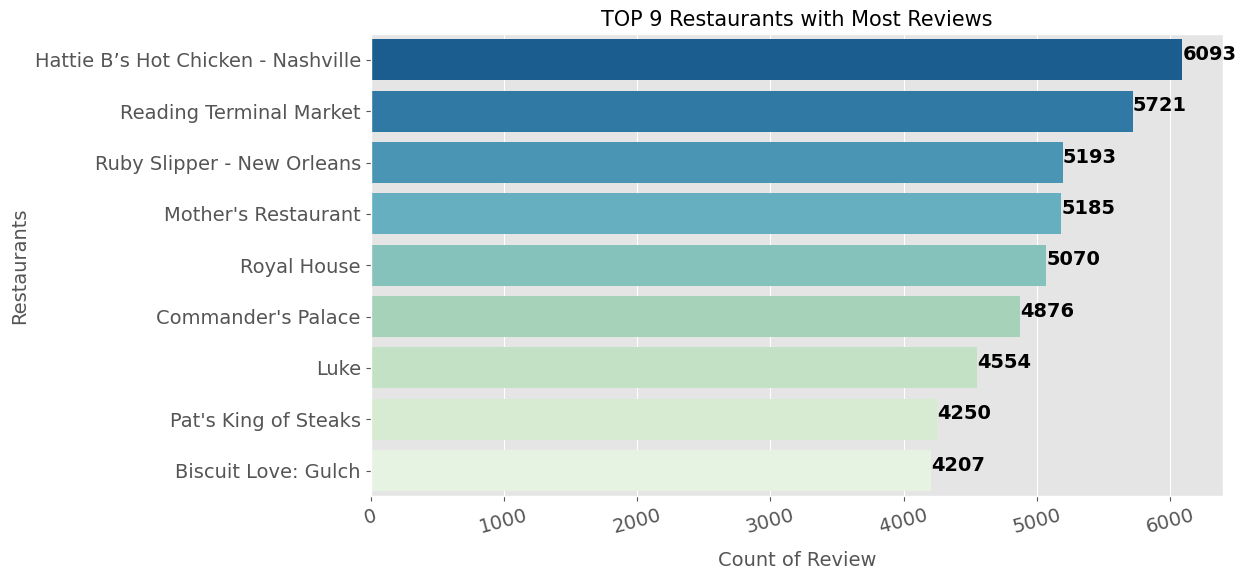

In [62]:
#Top 9 restaurants with most reviews
plt.figure(figsize=(11,6))
grouped = us_restaurants[['name','review_count']].sort_values(by='review_count', ascending=False)[:9]
sns.barplot(x=grouped.review_count, y = grouped.name, palette=sns.color_palette("GnBu_r", len(grouped)), ci=None)
plt.xlabel('Count of Review', labelpad=10, fontsize=14)
plt.ylabel('Restaurants', fontsize=14)
plt.title('TOP 9 Restaurants with Most Reviews', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped.review_count):
    plt.text(v, i, str(v), fontweight='bold', fontsize=14)

In [63]:
#Distribution of positive and negative reviews in each category

table = pd.pivot_table(restaurants_reviews, values=["user_id"], index=["category"],columns=["labels"], 
                       aggfunc=len, margins=True, dropna=True,fill_value=0)
table

user_id                  
labels        negative positive      All
category                                
American        352127  1144197  1496324
Chinese          50424   139369   189793
French            6469    31968    38437
Greek             2827    12247    15074
Hawaiian          1545     8660    10205
Indian           11315    50386    61701
Italian          73703   222134   295837
Japanese         32633   120974   153607
Korean            3517    20222    23739
Mediterranean    14044    74240    88284
Mexican          79650   226461   306111
Thai             11926    59411    71337
Vietnamese        8179    41690    49869
All             648359  2151959  2800318

In [64]:
table_percentage = table.div( table.iloc[:,-1], axis=0).iloc[:-1,-2].sort_values(ascending=False)
table_percentage

category
Korean           0.851847
Hawaiian         0.848604
Mediterranean    0.840922
Vietnamese       0.835990
Thai             0.832822
French           0.831699
Indian           0.816616
Greek            0.812459
Japanese         0.787555
American         0.764672
Italian          0.750866
Mexican          0.739800
Chinese          0.734321
Name: (user_id, positive), dtype: float64

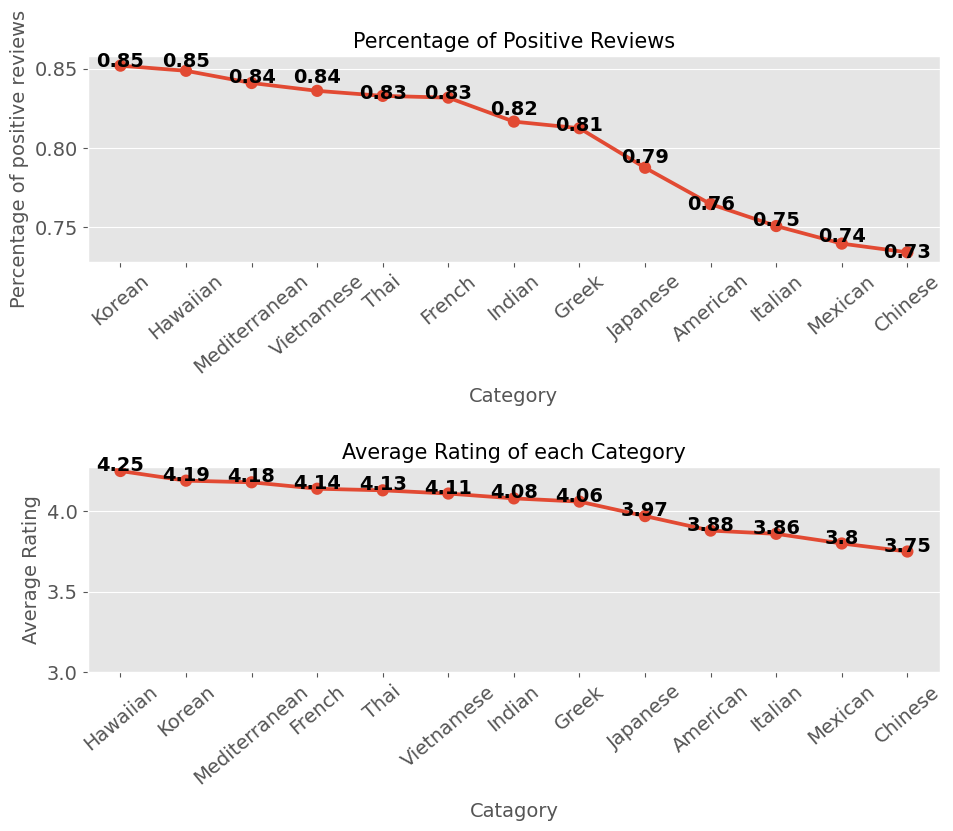

In [65]:
plt.figure(figsize=(11,8))
plt.subplot(211)
sns.pointplot(x=table_percentage.index, y= table_percentage.values)
plt.xlabel('Category', labelpad=7, fontsize=14)
plt.ylabel('Percentage of positive reviews', fontsize=14)
plt.title('Percentage of Positive Reviews', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=40)
for  i, v in enumerate(table_percentage.round(2)):
    plt.text(i, v*1.001, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    
plt.subplot(212)
grouped = restaurants_reviews.groupby('category')['review_star'].mean().round(2).sort_values(ascending=False)
sns.pointplot(x = grouped.index, y= grouped.values)
plt.ylim(3)
plt.xlabel('Catagory', labelpad=10, fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.title('Average Rating of each Category', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=40)
for  i, v in enumerate(grouped):
    plt.text(i, v, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    
plt.subplots_adjust(hspace=1)

### Review analysis

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

In [98]:
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.svm import LinearSVC

from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [ ]:
## convert text to lower case
restaurants_reviews.text = restaurants_reviews.text.str.lower()

## remove unnecessary punctuation
restaurants_reviews['removed_punct_text']= restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','')

In [79]:
## import positive file which contains common meaningless positive words such as good
file_positive = open('positive.txt')
reader =csv.reader(file_positive)
positive_words = [word[0] for word in reader]

## import negative file which contains common meaningless positive words such as bad
file_negative = open('negative.txt',encoding='ISO-8859-1')
reader =csv.reader(file_negative)
negative_words = [word[0] for word in reader]

In [80]:
## get dataset by category
def get_dataset(category):
    df = restaurants_reviews[['removed_punct_text','labels']][restaurants_reviews.category==category]
    df.reset_index(drop=True, inplace =True)
    df.rename(columns={'removed_punct_text':'text'}, inplace=True)
    return df



## only keep positive and negative words
def filter_words(review):
    words = [word for word in review.split() if word in positive_words + negative_words]
    words = ' '.join(words)
    return words

In [81]:
def split_data(dataset, test_size):
    df_train, df_test = train_test_split(dataset[['text','labels']],test_size=test_size)
    return df_train

In [168]:
def get_polarity_score(dataset):
    dataset.text = dataset.text.apply(filter_words)
    
    terms_train=list(dataset['text'])
    class_train=list(dataset['labels'])
    
    
    vectorizer = TfidfVectorizer() 
    feature_train_counts = vectorizer.fit_transform(terms_train)
    '''
    
    ## get bag of words
    vectorizer = CountVectorizer()
    feature_train_counts=vectorizer.fit_transform(terms_train)
    '''
    ## run model
    svm = LinearSVC()
    svm.fit(feature_train_counts, class_train)
    
    ## create dataframe for score of each word in a review calculated by svm model
    coeff = svm.coef_[0]
    cuisine_words_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names()})

    
    cuisine_words_score.set_index('word', inplace=True)
    cuisine_polarity_score = cuisine_words_score
    
    ## drop unnecessary words
    unuseful_positive_words = ['great','amazing','love','best','awesome','excellent','good',
                                                   'favorite','loved','perfect','gem','perfectly','wonderful','happy','enjoyed','nice','well','super','like','better','decent','fine',
                                                    'pretty','enough','excited','impressed','ready','fantastic','glad','right',
                                                    'fabulous']
    unuseful_negative_words =  ['bad','disappointed','unfortunately','disappointing','horrible',
                                                    'lacking','terrible','sorry']
    unuseful_words = unuseful_positive_words + unuseful_negative_words
    cuisine_polarity_score.drop(cuisine_polarity_score.loc[unuseful_words].index, axis=0, inplace=True)
    return cuisine_polarity_score
    '''
    
    ## get frequency of each word in all reviews in specific category
    cuisine_reviews = pd.DataFrame(feature_train_counts.toarray(), columns=vectorizer.get_feature_names())
    cuisine_reviews['labels'] = class_train
    cuisine_frequency = cuisine_reviews[cuisine_reviews['labels'] =='positive'].sum()[:-1]
    
    cuisine_words_score.set_index('word', inplace=True)
    cuisine_polarity_score = cuisine_words_score
    cuisine_polarity_score['frequency'] = cuisine_frequency
    
    cuisine_polarity_score.score = cuisine_polarity_score.score.astype(float)
    cuisine_polarity_score.frequency = cuisine_polarity_score.frequency.astype(int)
    
    ## calculate polarity score 
    cuisine_polarity_score['polarity'] = cuisine_polarity_score.score * cuisine_polarity_score.frequency / cuisine_reviews.shape[0]
    
    cuisine_polarity_score.polarity = cuisine_polarity_score.polarity.astype(float)
    return cuisine_polarity_score
    '''
                                                   

In [178]:
def plot_top_words(df, category):
    
    top_10_positive = df[df.score >0].sort_values('score',ascending = False)[:10]
    top_10_negative = df[df.score <0].sort_values('score')[:10]
    top_positive_words = list(top_10_positive.index)
    top_negative_words = list(top_10_negative.index)
    top_words = top_words = top_positive_words + top_negative_words
    top_words = df[df.index.isin(top_words)].sort_values('score', ascending=False)
    '''
    plt.figure(figsize=(11,6))
    colors = ['red' if c < 0 else 'blue' for c in top_words.values]
    sns.barplot(y=top_words.index, x=top_words['score'].values, palette=colors)
    plt.xlabel('Polarity Score', labelpad=10, fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.title('TOP 10 Positive and Negative Words in %s Restaurants ' % category, fontsize=15)
    plt.tick_params(labelsize=14)
    plt.xticks(rotation=15)
'''
    plt.figure(figsize=(11,6))
    colors = ['#FFA500' if c < 0 else '#4169E1' for c in top_words.values]
    sns.barplot(y=top_words.index, x=top_words['score'].values, palette=colors)
    plt.xlabel('Polarity Score', labelpad=10, fontsize=14, color='#2F4F4F')
    plt.ylabel('Words', fontsize=14, color='#2F4F4F')
    plt.title('TOP 10 Positive and Negative Words in %s Restaurants ' % category, fontsize=15, color='#2F4F4F')
    plt.tick_params(labelsize=14, color='#2F4F4F')
    plt.xticks(rotation=15, color='#2F4F4F')
    plt.yticks(color='#2F4F4F')
    # plt.gca().set_facecolor('#FFFFFF')



    '''
    top_10_positive = df[df.polarity >0].sort_values('polarity',ascending = False)[:10]
    top_10_negative = df[df.polarity <0].sort_values('polarity')[:10]
    top_positive_words = list(top_10_positive.index)
    top_negative_words = list(top_10_negative.index)
    top_words = top_words = top_positive_words + top_negative_words
    top_words = df[df.index.isin(top_words)].sort_values('polarity', ascending=False)
    
    plt.figure(figsize=(11,6))
    colors = ['red' if c < 0 else 'blue' for c in top_words['polarity'].values]
    sns.barplot(y=top_words.index, x=top_words['polarity'].values, palette=colors)
    plt.xlabel('Polarity Score', labelpad=10, fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.title('TOP 10 Positive and Negative Words in %s Restaurants ' % category, fontsize=15)
    plt.tick_params(labelsize=14)
    plt.xticks(rotation=15)
    '''

## Analyze the restaurant by type

In [ ]:
Korean_reviews = get_dataset('Korean')
Korean_polarity_score = get_polarity_score(Korean_reviews)
plot_top_words(Korean_polarity_score,'Korean')

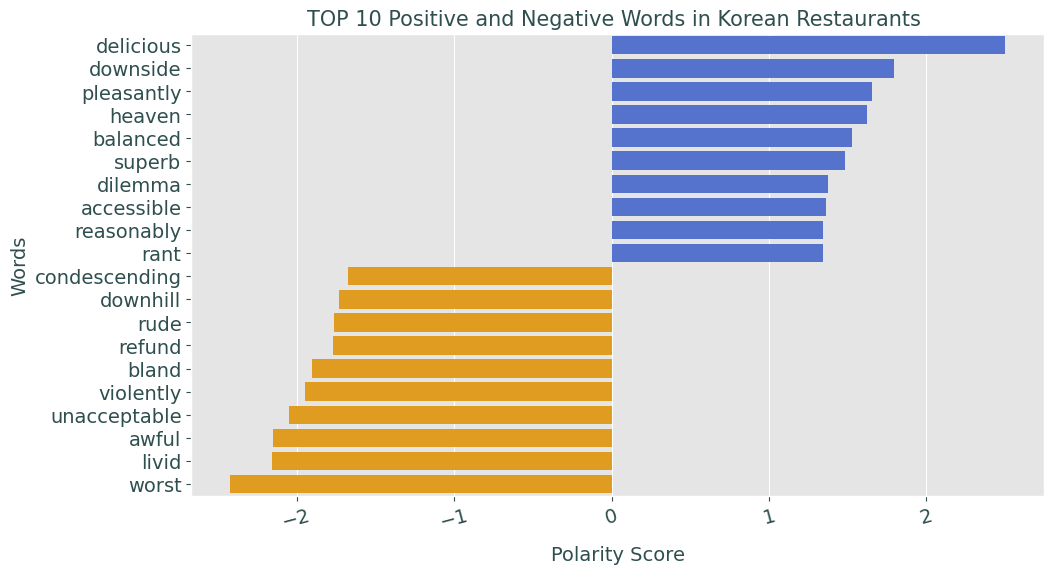

In [179]:
plot_top_words(Korean_polarity_score,'Korean')

/Users/siying/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


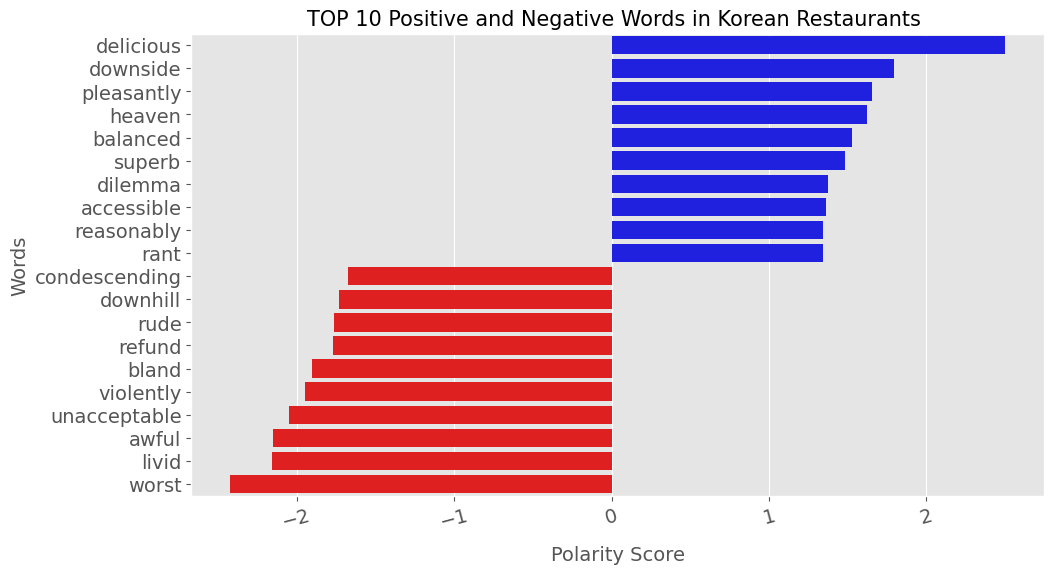

In [170]:
# TIF
Korean_reviews = get_dataset('Korean')
Korean_polarity_score = get_polarity_score(Korean_reviews)
plot_top_words(Korean_polarity_score,'Korean')

/Users/siying/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/siying/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


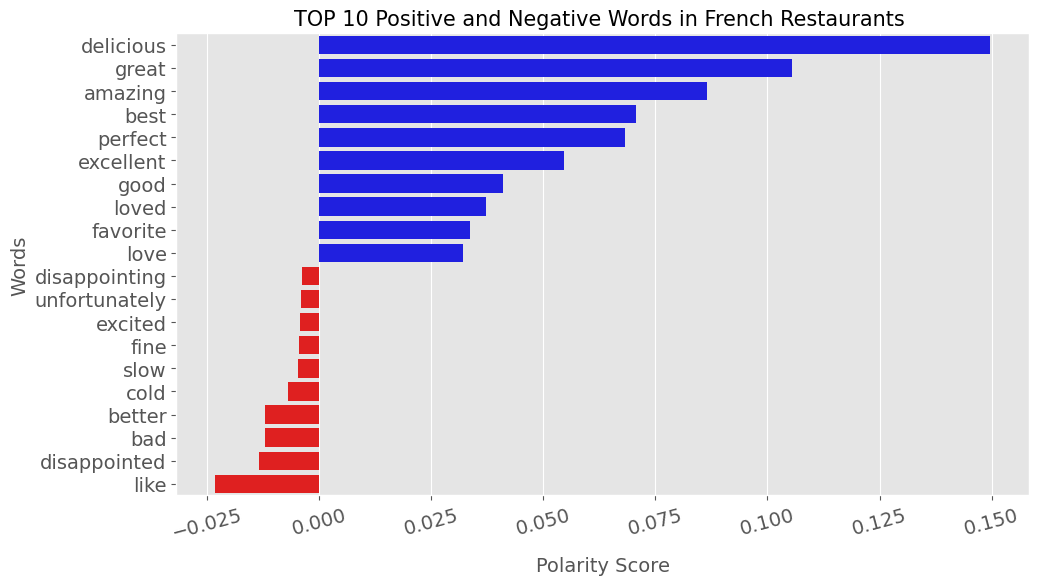

In [146]:
French_reviews = get_dataset('French')
French_polarity_score = get_polarity_score(French_reviews)
plot_top_words(French_polarity_score,'French')

In [ ]:
# TF-IDF
French_reviews = get_dataset('French')
French_polarity_score = get_polarity_score(French_reviews)
plot_top_words(French_polarity_score,'French')

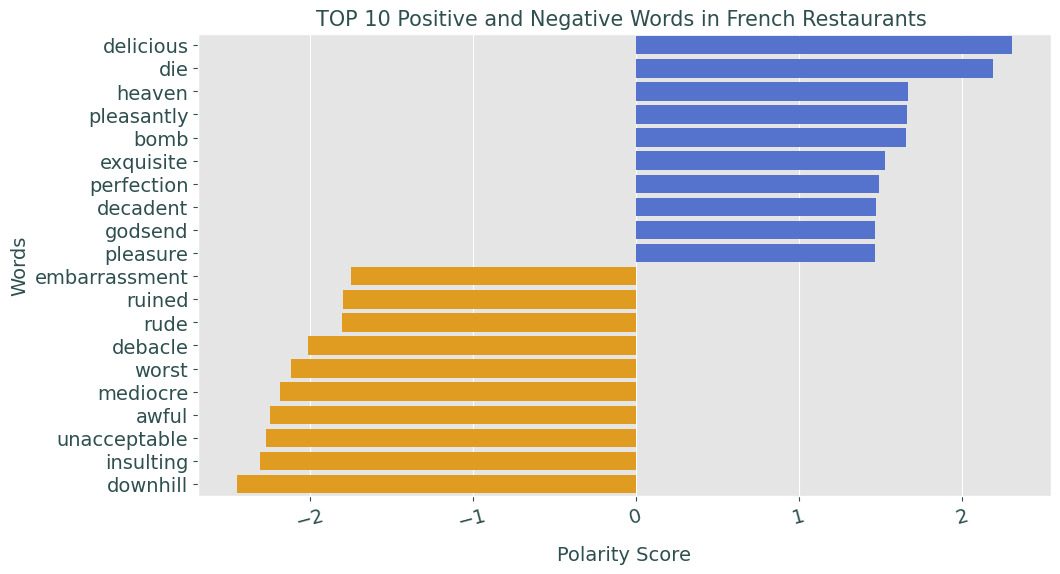

In [180]:
plot_top_words(French_polarity_score,'French')

## Analyze the restaurant by city

In [191]:
def get_dataset_city(city):
    df = restaurants_reviews[['removed_punct_text','labels']][restaurants_reviews.city==city]
    df.reset_index(drop=True, inplace =True)
    df.rename(columns={'removed_punct_text':'text'}, inplace=True)
    return df

In [187]:
restaurants_reviews.city.value_counts()

Philadelphia           415946
New Orleans            213752
Nashville              208562
Tampa                  187297
Tucson                 162475
                        ...  
Linwood                     4
Pittsgrove Township         4
East St. Louis              3
Swedeland                   3
Hancock                     2
Name: city, Length: 739, dtype: int64

In [193]:
restaurants_reviews[restaurants_reviews.city =='Santa Barbara' ].shape

(106374, 19)

### Carpinteria resturants positive and negative words

/Users/siying/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


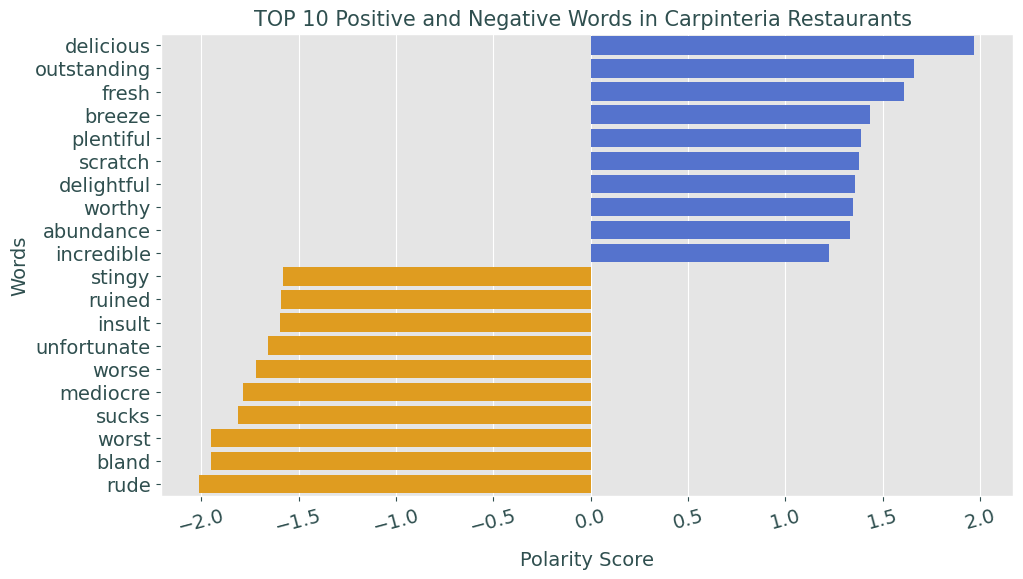

In [192]:
Carp_reviews = get_dataset_city('Carpinteria')
Carp_polarity_score = get_polarity_score(Carp_reviews)
plot_top_words(Carp_polarity_score,'Carpinteria')

### Tucson resturants positive and negative words

### Santa Barbara resturants positive and negative words

/Users/siying/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


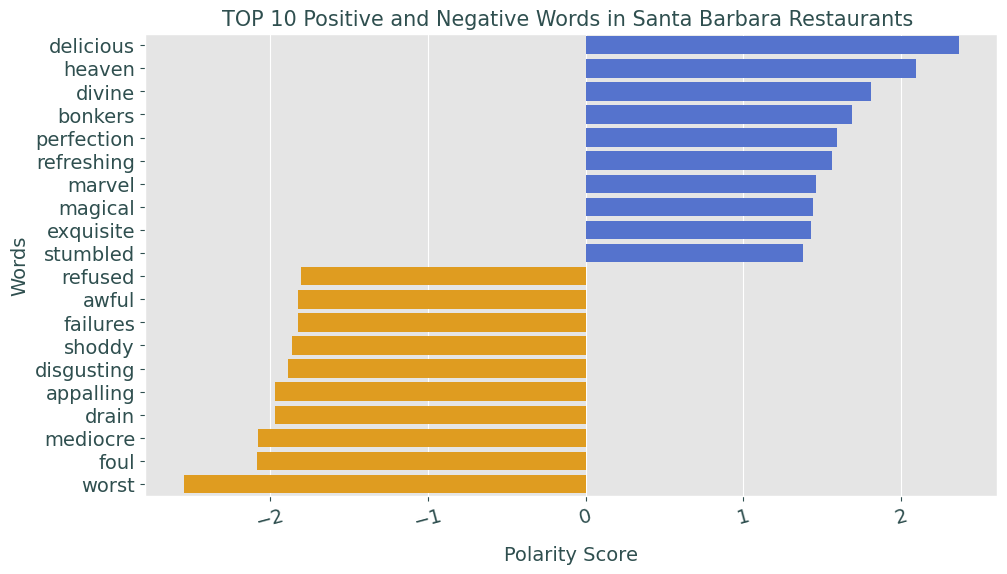

In [194]:
Santa_reviews = get_dataset_city('Santa Barbara')
Santa_polarity_score = get_polarity_score(Santa_reviews)
plot_top_words(Santa_polarity_score,'Santa Barbara')